In [1]:
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

from scipy import stats
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50V2, DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, Activation, GlobalAveragePooling2D, BatchNormalization

import os
import cv2
import glob
import pickle
import random
import warnings

In [2]:
batch_size = 32
img_height = 128
img_width = 128
epochs = 30
num_classes = 28
img_channels = 3

In [3]:
main_folder_path = r"D:\SixthSemProjects\ASL_Alphabet_Dataset\asl_alphabet_train"
subfolders = os.listdir(main_folder_path)

In [4]:
print(subfolders)

['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


IndexError: index 30 is out of bounds for axis 0 with size 30

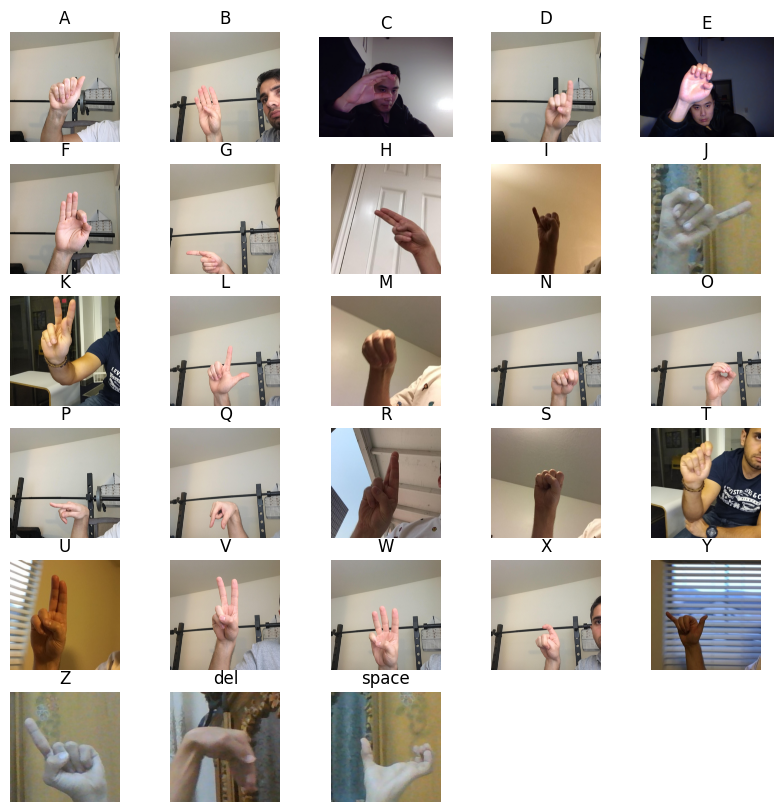

In [ ]:
categories = {}
label = []
count = []

# Create a figure to display the images
rows = 6
columns = 5
fig, axs = plt.subplots(rows, columns, figsize=(10, 10))
ax = axs.ravel()

# Iterate through each subfolder and display the first image
for index, subfolder in enumerate(sorted(subfolders)):
    plt.xticks([])
    plt.yticks([])

    categories[index] = subfolder

    # print('subfolder', subfolder, i)
    subfolder_path = os.path.join(main_folder_path, subfolder)
    image_files = os.listdir(subfolder_path)

    count.append(len(image_files))
    label.append(subfolder)

    # Load the first image in the subfolder
    image_path = os.path.join(subfolder_path, image_files[0])
    img = mimg.imread(image_path)

    # Display the image using plt.imshow
    ax[index].imshow(img)
    ax[index].set_title(subfolder)
    ax[index].axis('off')


df = pd.DataFrame({'Label': label, 'Count': count})

ax[index+1].set_axis_off()
ax[index+2].set_axis_off()
ax[index+3].set_axis_off()


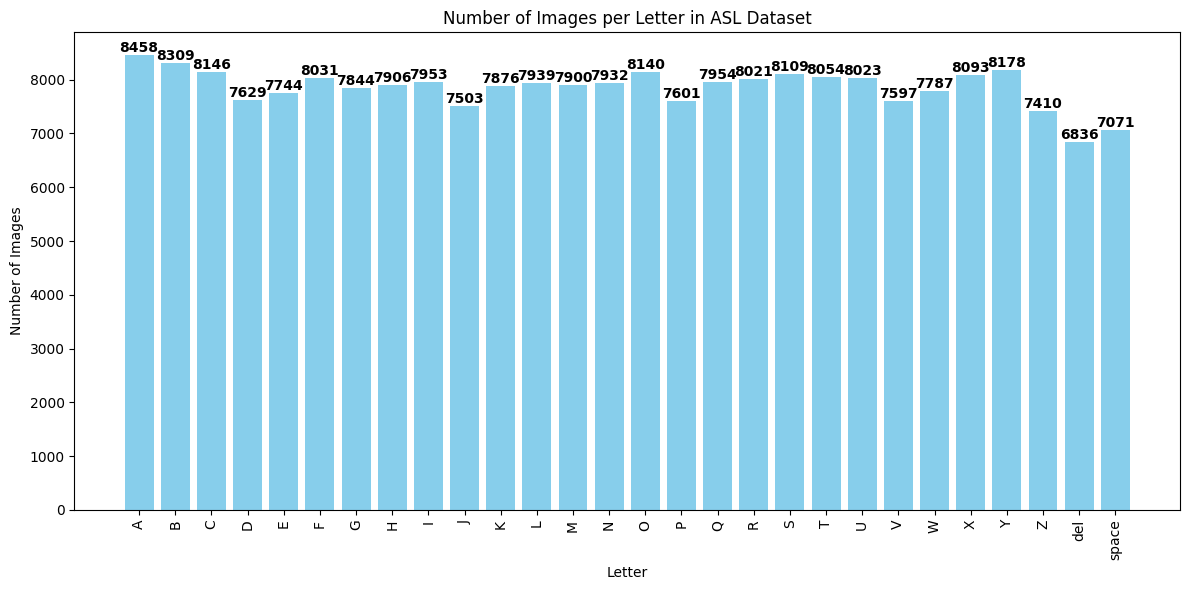

In [6]:
main_folder_path = 'D:\\SixthSemProjects\\ASL_Alphabet_Dataset\\asl_alphabet_train'

subfolders = [folder for folder in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, folder))]

image_counts = {}

for letter in subfolders:
    subfolder_path = os.path.join(main_folder_path, letter)
    letter_files = os.listdir(subfolder_path) 
    image_counts[letter] = len(letter_files)  


sorted_letters = sorted(image_counts.keys())
sorted_counts = [image_counts[letter] for letter in sorted_letters]

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_letters, sorted_counts, color='skyblue')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), 
             ha='center', va='bottom', fontweight='bold', fontsize=10)
    
plt.xlabel('Letter')
plt.ylabel('Number of Images')
plt.title('Number of Images per Letter in ASL Dataset')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
labels = list(categories.values())

list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(main_folder_path, label, "*")
    image_files = glob.glob(label_path)  #returns all images from the label_path ie from sign a all the images within it

    sign_label = [label] * len(image_files) #image file should be 5000 i think, so 5000 labels


    list_path.extend(image_files)
    list_labels.extend(sign_label)

dataframe = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataframe["image_path"],dataframe["label"],test_size=0.15,random_state=2024,shuffle=True,stratify = dataframe["label"])

train_df = pd.DataFrame({"image_path": X_train,"label": y_train})

X_train, X_val, y_train, y_val = train_test_split(train_df["image_path"], train_df["label"],test_size=0.20,random_state=2024,shuffle=True,stratify=train_df["label"])

train_df = pd.DataFrame({"image_path": X_train,"label": y_train})

val_df = pd.DataFrame({"image_path": X_val,"label": y_val})

test_df = pd.DataFrame({"image_path": X_test,"label": y_test})

NameError: name 'train_test_split' is not defined

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.,)

# Training Dataset
train_gen = datagen.flow_from_dataframe(
    train_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    batch_size=batch_size,
    target_size=(img_height, img_width),
)

# Validation Dataset
val_gen = datagen.flow_from_dataframe(
    val_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    batch_size=batch_size,
    target_size=(img_height, img_width),
)

# Testing Dataset
test_gen = datagen.flow_from_dataframe(
    test_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    batch_size=1,
    target_size=(img_height, img_width),
    shuffle=False
)


Found 149629 validated image filenames belonging to 28 classes.
Found 37408 validated image filenames belonging to 28 classes.
Found 33007 validated image filenames belonging to 28 classes.


In [10]:
image_shape = (128, 128, 3)
print(200*200*3)
print(128*128*3)

120000
49152


In [11]:
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=5,
                              restore_best_weights=True,
                              verbose=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                        patience=2,
                                        factor=0.5,
                                        verbose=True)

checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

# Image properties
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 11
def inverted_residual_block(x, in_channels, out_channels, expansion_factor, stride):
    """Creates an inverted residual block (like MobileNetV2)"""

    # Expansion
    expanded_channels = in_channels * expansion_factor
    x = Conv2D(expanded_channels, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU(6.0)(x)  # ReLU6 activation

    # Depthwise Convolution
    x = DepthwiseConv2D((3, 3), strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU(6.0)(x)

    # Projection (Linear Bottleneck)
    x = Conv2D(out_channels, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Residual Connection (if stride is 1 and input channels match output channels)
    if stride == 1 and x.shape[-1] == out_channels:
        shortcut = x  # Store the original input
        x = Add()([x, shortcut])  # Add the residual connection

    return x


def custom_mobilenetv2(input_shape=(128, 128, 3), num_classes=29):
    """Builds a custom CNN similar to MobileNetV2"""

    inputs = Input(shape=input_shape)

    # Initial Convolution Layer
    x = Conv2D(32, (3, 3), strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU(6.0)(x)

    # Inverted Residual Blocks (like MobileNetV2)
    x = inverted_residual_block(x, in_channels=32, out_channels=16, expansion_factor=1, stride=1)
    x = inverted_residual_block(x, in_channels=16, out_channels=24, expansion_factor=6, stride=2)
    x = inverted_residual_block(x, in_channels=24, out_channels=24, expansion_factor=6, stride=1)
    x = inverted_residual_block(x, in_channels=24, out_channels=32, expansion_factor=6, stride=2)

    # Global Average Pooling and Output Layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True
)

# Load Data
train_generator = datagen.flow_from_directory(
    main_folder_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    main_folder_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

# Get class labels
num_classes = len(train_generator.class_indices)

# Build and compile the model
model = custom_mobilenetv2(num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    verbose=1
)

# Save the trained model
model.save("asl_mobilenetv2_model.h5")
print("MobileNetV2-based ASL model saved!")

# Save the training history
with open("training_history_mobilenetv2.pkl", "wb") as f:
    pickle.dump(history.history, f)
print("Training history saved!")

Found 176048 images belonging to 28 classes.
Found 43996 images belonging to 28 classes.
Epoch 1/11
  22/2751 [..............................] - ETA: 40:53 - loss: 3.3358 - accuracy: 0.0455

KeyboardInterrupt: 

In [1]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]